# Data Analysis for Master Thesis Project

## Environment Preparation

In [230]:
# import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import data_prep
import survey_data
from functools import reduce
import pingouin as pg
from pathlib import Path
import statsmodels.api as sm
import pandas as pd
import numpy as np

## Preprocessing

In the preprocessing the datafile wich is created automatically from PsychPy is transformed into a clean format so that analysis can be done. For that reason all available files are read and the prepare data function from the data_prep file is called. The practice trials are sorted out and a new index is created without holding the practice trial.
The questionnaire data is preprocessed in a separate step by calling the survey_data function from the survey_data file.
Both preprocessed data files are stored as csv files.

In [190]:
# List all data files which should be preprocessed
directory = Path('/Users/anja/Desktop/data_mt')
data_files = [file.name for file in directory.glob('*.csv')]

In [191]:
# Preprocess data from experiment
data = data_prep.prepare_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/data_prep.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_fill] = df[columns_to_fill].fillna(0)
/Users/anja/Documents/GitHub/master_thesis/data_prep.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_fill] = df[columns_to_fill].fillna(0)
/Users/anja/Documents/GitHub/master_thesis/data_prep.py:108: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in

In [192]:
# Detele practice trials and create practice subset
practice_trials = data[data['block'] == 'Test']
data = data[data['block'] != 'Test']

In [193]:
# Create trial index per participant (after test trials were deleted!)
data['trial_index_within_participant'] = data.groupby('participant').cumcount() + 1

In [194]:
# Preprocess data from pavlovia surveys (questionnaire answers)
survey_data = survey_data.survey_data(data_files)

/Users/anja/Documents/GitHub/master_thesis/survey_data.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  concatenated_df = pd.concat(dfs, ignore_index=True)


In [195]:
# Store preprocessed data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_preprocessed.csv', index=False)
survey_data.to_csv('/Users/anja/Desktop/data_mt/data_survey.csv', index=False)

In [196]:
# Number of trails initially available
data.shape[0]

34178

## Demographic Data

In this section the demographic data from the survey dataset is analysed to find out how handedness, gender and age are distributed among participants.

In [197]:
# Summarize handedness
survey_data['handedness'].describe()

count        90
unique        3
top       right
freq         84
Name: handedness, dtype: object

In [198]:
# Summarize age
survey_data['age'].describe()

count    90.000000
mean     29.244444
std       6.309100
min      19.000000
25%      24.000000
50%      28.000000
75%      33.000000
max      44.000000
Name: age, dtype: float64

In [199]:
# Summarize gender
survey_data['gender'].describe()

count       90
unique       3
top       male
freq        53
Name: gender, dtype: object

## Unrealistic response times

It seems like some participants cheated, therefore we need to sort out their data

compare relavant_participants with relevant_participants_filtered to see how many were sorted out (adjust the number of stds to filter out more or less)

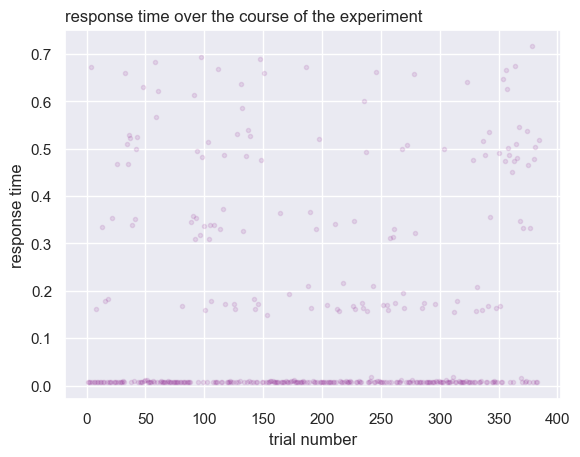

In [200]:
# Plot with transparency
data_787053 = data[data['participant']==787053]
plt.plot( data_787053["trial_index_within_participant"], data_787053["owner_confirm_rt"], data=data_787053, linestyle='', marker='o', markersize=3, alpha=0.1, color="purple")
 
# Titles
plt.xlabel('trial number')
plt.ylabel('response time')
plt.title('response time over the course of the experiment', loc='left')
plt.show()

In [201]:
# Filter out data with unrealistic response times (less or more than 1 std from average response time)
relevant_participants = data.groupby(['participant']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Calculate mean and std
mean_response_time = data['owner_confirm_rt'].mean()
std_response_time = data['owner_confirm_rt'].std()

# Calculate bounds
lower_bound = mean_response_time - 1 * std_response_time
upper_bound = mean_response_time + 1 * std_response_time

# Filter relevant participants
relevant_participants_filtered = relevant_participants[
    (relevant_participants['average_response_time'] >= lower_bound) &
    (relevant_participants['average_response_time'] <= upper_bound)
]

# Left join of data with relevant_participants_filtered to sort out participants who cheated
data = data.merge(relevant_participants_filtered[['participant']], on='participant', how='inner')

## Error rates
Since participants have trials where they have been asked to respond faster or reiterate their response because they did not confirm correctly, we'll need to decide which of those trials to keep for analysis and which to sort out. In order to do so, error rates of participants are analysed.

In [202]:
# Error rates per participant
# Add bool column for error in decision
data['error_in_decision'] = data[['bool_slow_color_choice_or_confirm', 'bool_wrong_color_confirm']].any(axis=1).astype(int)

# Add bool column for error in owner confirm
data['error_in_outcome_attribution'] = data[['bool_slow_owner_confirm', 'bool_wrong_owner_confirm']].any(axis=1).astype(int)

# Group by participant and sum the errors
errors_per_participant = data.groupby('participant')[['error_in_decision', 'error_in_outcome_attribution']].sum().reset_index()

# Calculate ratios
total_trials = 384
errors_per_participant['error_in_decision_ratio'] = round(((errors_per_participant['error_in_decision'] / total_trials) * 100),2)
errors_per_participant['error_in_outcome_attribution_ratio'] = round(((errors_per_participant['error_in_outcome_attribution'] / total_trials) *100),2)

errors_per_participant.describe()

,participant,error_in_decision,error_in_outcome_attribution,error_in_decision_ratio,error_in_outcome_attribution_ratio
count,85.000000,85.000000,85.000000,85.000000,85.000000
mean,452866.764706,13.141176,39.800000,3.420941,10.365412
std,332945.049039,12.105836,30.595985,3.153290,7.967710
min,3157.000000,1.000000,5.000000,0.260000,1.300000
25%,153234.000000,6.000000,17.000000,1.560000,4.430000
50%,470738.000000,9.000000,35.000000,2.340000,9.110000
75%,764660.000000,15.000000,47.000000,3.910000,12.240000
max,999482.000000,58.000000,148.000000,15.100000,38.540000


In [203]:
# Filter out participants which did too many error in outcome attribution (more or less than 2,5 stds)
# Calculate mean and std
mean_error = errors_per_participant['error_in_outcome_attribution'].mean()
std_error = errors_per_participant['error_in_outcome_attribution'].std()

# Calculate bounds
lower_bound = mean_error - 2.5 * std_error
upper_bound = mean_error + 2.5 * std_error

# Filter relevant participants
errors_per_participant_filtered = errors_per_participant[
    (errors_per_participant['error_in_outcome_attribution'] >= lower_bound) &
    (errors_per_participant['error_in_outcome_attribution'] <= upper_bound)]

# Left join of data with relevant_participants_filtered to sort out participants who cheated
data = data.merge(errors_per_participant_filtered[['participant']], on='participant', how='inner')

In [204]:
# Total number of trails from filtered participants
total_trials_filtered = data.shape[0]
print(total_trials_filtered)

31488


In [205]:
# Clean from rows where outcome attribution response was too slow or wrong 
data = data[(data['bool_slow_owner_confirm'] == False) & 
            (data['bool_wrong_owner_confirm'] == False)]

# Store cleaned data in csv
data.to_csv('/Users/anja/Desktop/data_mt/data_cleaned.csv', index=False)

In [206]:
# Ratio of trails from filtered participants ending up in the analysis
round(data.shape[0] / total_trials_filtered,2)

0.91

In [207]:
# Number of participants ending up in the analysis
len(data['participant'].unique())

82

## Analysis

In [208]:
# Optional: sample for a lower number of participants
'''
# Sample for 22 participants just for fun
unique_participants = data['participant'].unique()
sample = pd.Series(unique_participants).sample(n=22)
data = data[data['participant'].isin(sample)]
'''

"\n# Sample for 22 participants just for fun\nunique_participants = data['participant'].unique()\nsample = pd.Series(unique_participants).sample(n=22)\ndata = data[data['participant'].isin(sample)]\n"

### Normal Distribution

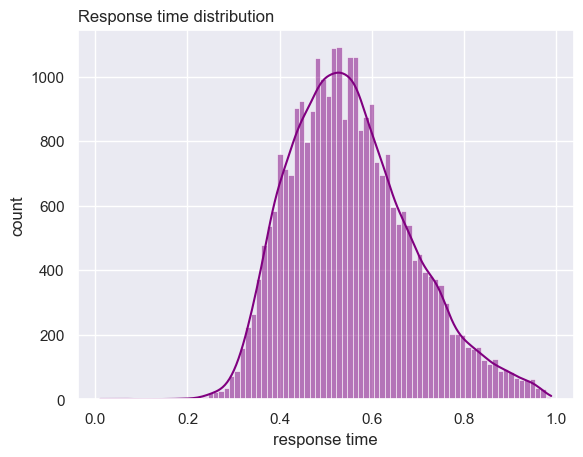

In [209]:
# Histogram of all response times
sns.set_theme(style="darkgrid")

sns.histplot(data=data, x="owner_confirm_rt", color="purple", kde=True)

plt.title('Response time distribution', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.show()

### Confirm previous results from Abubshait et. al

Are participants faster when confirming give or when confirming keep?

1) In original study participants were faster when outcome was kept by themselves, slower when outcome was given to Cozmo (no matter what outcome value)

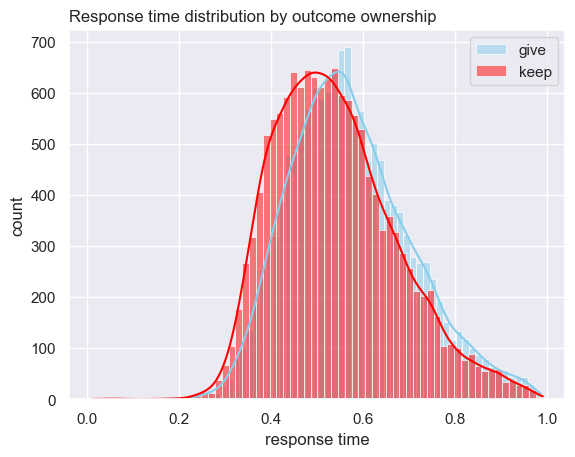

In [210]:
# Histogram of response times
# TODO: mirror https://python-graph-gallery.com/density-mirror/
sns.set_theme(style="darkgrid")

sns.histplot(data=data[data['owner_confirm_keys'] == 'g'], x="owner_confirm_rt", color="skyblue", label="give", kde=True)
sns.histplot(data=data[data['owner_confirm_keys'] == 'k'], x="owner_confirm_rt", color="red", label="keep", kde=True)

plt.title('Response time distribution by outcome ownership', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.legend() 
plt.show()

2. In original study when the outcome was kept by oneself it was easier to keep wins and harder to keep losses. This was only found for the participant as outcome owner, not for the robot as outcome owner. This could mean that participants are less invested / interested in the outcomes of Cozmo. There is a differentiation between Cozmo and oneself.

In [211]:
# Group by owner, value
data.groupby(['owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,owner,value,average_response_time,median_response_time
0,cozmo,lose,0.568788,0.5559
1,cozmo,win,0.576507,0.5618
2,you,lose,0.553916,0.5378
3,you,win,0.526021,0.5074


3. In original study participants were faster when the outcome value was winning, no matter which outcome owner it was.

--> Since we already know that giving is harder (takes longer) than keeping, this is probalby anyways driven by the outcome owner = "you" condition

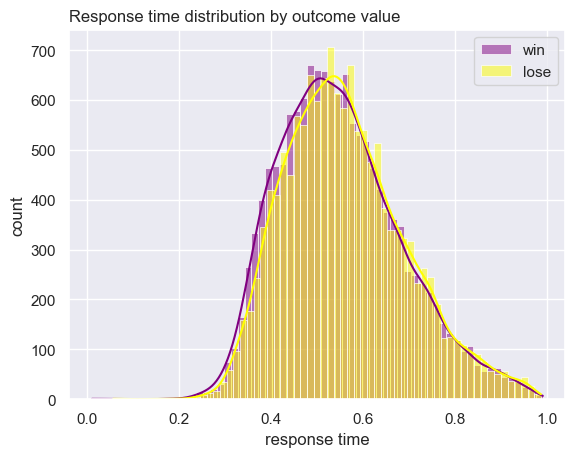

In [212]:
# Histogram of response times
sns.set_theme(style="darkgrid")

sns.histplot(data=data[data['value'] == 'win'], x="owner_confirm_rt", color="purple", label="win", kde=True)
sns.histplot(data=data[data['value'] == 'lose'], x="owner_confirm_rt", color="yellow", label="lose", kde=True)

plt.title('Response time distribution by outcome value', loc='left')
plt.xlabel('response time')
plt.ylabel('count')

plt.legend() 
plt.show()

4. Elevated response conflict when giving a win (as compared to give a loss) to Cozmo

One can see this in the differences between giving and keeping for “Win” outcomes (difference is larger) compared to the difference between keeping and giving “Lose” outcomes (smaller difference in reponse times). 

"Since we know that giving in general is harder than keeping, the especially hard condition is to give a win"

In [213]:
data.groupby(['value', 'owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,value,owner,average_response_time,median_response_time
0,lose,cozmo,0.568788,0.5559
1,lose,you,0.553916,0.5378
2,win,cozmo,0.576507,0.5618
3,win,you,0.526021,0.5074


#### Re-Examine ANOVA

original paper: "To measure cognitive conflict, participants' reaction times (RTs) to confirm the Keep-Give assignment were analyzed. RTs were averaged for correct trials that were within +/3SD of the overall mean. Averaged RTs were subjected to a 2x2 repeated measures ANOVA with Assignment (Keep vs. Give) and Outcome (Win vs. Lose) as within-factors. Analyses were conducted using R."

--> what was averaged? for each participant or for condition set?

--> sort out sinlge trials were answer was wrong or data of participant?

--> other methods in python are statsmodels package, or pyvttbl

--> df1 ist für alle varialben 1, df2 ist 150 - 8 conditions = 142 --> F(1,142) ; correct for number of participants in the end

--> original paper also did following t tests

In [214]:
# Pingouin ANOVA
anova = pg.rm_anova(dv='owner_confirm_rt', within=['value', 'owner'], data=data, subject='participant', detailed=True)

print(anova)

          Source        SS  ddof1  ddof2        MS           F         p-unc  \
0          value  0.008169      1     81  0.008169   27.733925  1.121348e-06   
1          owner  0.086618      1     81  0.086618  118.534015  1.580864e-17   
2  value * owner  0.026114      1     81  0.026114   38.598347  2.124879e-08   

      p-GG-corr       ng2  eps  
0  1.121348e-06  0.005596  1.0  
1  1.580864e-17  0.056307  1.0  
2  2.124879e-08  0.017670  1.0  


/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/anja/Documents/GitHub/master_thesis/env/lib/python3.9/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


### Results considering Chooser

Text(0, 0.5, 'response time')

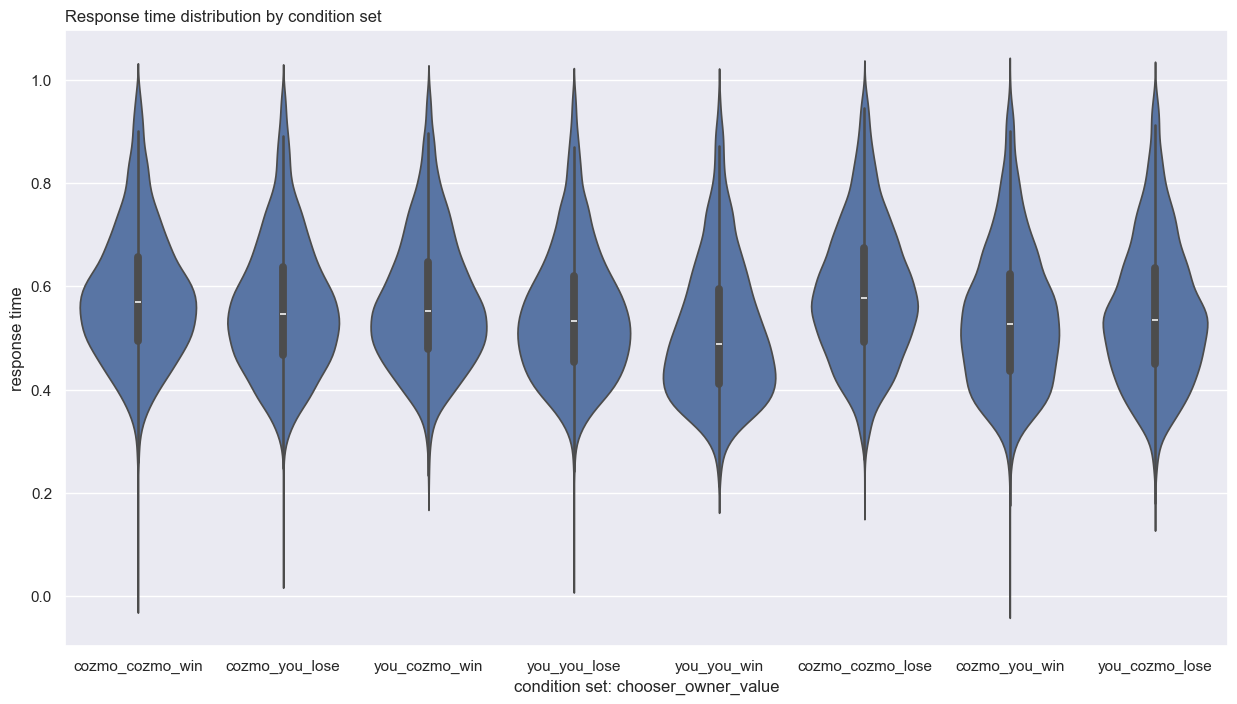

In [215]:
# Reaction time per condition group 
# https://python-graph-gallery.com/39-hidden-data-under-boxplot/
# sns.boxplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"] )
plt.figure(figsize=(15, 8)) 
sns.violinplot( x=data["identifier_chooser_owner_value_corr"], y=data["owner_confirm_rt"] )

plt.title('Response time distribution by condition set', loc='left')
plt.xlabel('condition set: chooser_owner_value')
plt.ylabel('response time')


#### Descriptive Analysis

Since the original study found that any outcome given to Cozmo leads to heightened conflict, we assume that decision agency could have a positive shaping effect here. Meaning that when the robot has the agency in decision it makes it again easier to give any outcome because participants are overall less invested.

cozmo_cozmo would have smaller response times there (similar as you_you)

In [216]:
# Group by chooser, owner
data.groupby(['chooser','owner']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,average_response_time,median_response_time
0,cozmo,cozmo,0.585639,0.57205
1,cozmo,you,0.549733,0.53590
2,you,cozmo,0.559457,0.54435
3,you,you,0.529074,0.51100


In [217]:
# Group by owner, chooser, value
data.groupby(['chooser','owner', 'value']).agg(average_response_time=('owner_confirm_rt', 'mean'), median_response_time=('owner_confirm_rt', 'median')).reset_index()

,chooser,owner,value,average_response_time,median_response_time
0,cozmo,cozmo,lose,0.588090,0.57660
1,cozmo,cozmo,win,0.583006,0.56950
2,cozmo,you,lose,0.560928,0.54695
3,cozmo,you,win,0.539682,0.52700
4,you,cozmo,lose,0.550166,0.53460
5,you,cozmo,win,0.569929,0.55200
6,you,you,lose,0.547109,0.53210
7,you,you,win,0.512214,0.48760


#### Statistical Analysis

In [218]:
# Test for sphericity; Mauchly's; p should be greater 0.05
# https://datatab.net/tutorial/anova-with-repeated-measures

pg.sphericity(data=data, dv='owner_confirm_rt', subject= 'participant', within='identifier_chooser_owner_value_corr')

SpherResults(spher=True, W=78735592762451.5, chi2=-2510.2499673752836, dof=27, pval=1.0)

In [219]:
# Test for Homogenity; Levene's; p should be greater 0.05
#https://datatab.net/tutorial/levene-test
pg.homoscedasticity(data=data, dv='owner_confirm_rt', group='identifier_chooser_owner_value_corr')

,W,pval,equal_var
levene,9.662233,4.588446e-12,False


--> Problem: homogenity is not given, TODO: what to do now?
This is not so relevant for my study design since I am rather interested in the differences inside one participant, i would like to understand how response time changes within one participant. Not so much over all participants (e.g., response time is a personal measure and therefore it makes sense that there are differences between participants the important thing is within one participant)

In [220]:
# Statsmodels ANOVA
aovrm = sm.stats.AnovaRM(data=data, subject= 'participant', depvar='owner_confirm_rt', within=['owner','chooser','value'], aggregate_func='mean')
res = aovrm.fit()
print(res)

                      Anova
                    F Value  Num DF  Den DF Pr > F
--------------------------------------------------
owner               119.9182 1.0000 81.0000 0.0000
chooser              63.4394 1.0000 81.0000 0.0000
value                29.8656 1.0000 81.0000 0.0000
owner:chooser         1.5658 1.0000 81.0000 0.2144
owner:value          38.6120 1.0000 81.0000 0.0000
chooser:value         4.1278 1.0000 81.0000 0.0455
owner:chooser:value  35.8633 1.0000 81.0000 0.0000



In [221]:
# Pingouin ANOVA for corrected identifier (within factor with 8 levels)
anova = pg.rm_anova(dv='owner_confirm_rt', within='identifier_chooser_owner_value_corr', data=data, subject='participant',detailed=False)
print(anova)

                                Source  ddof1  ddof2          F         p-unc  \
0  identifier_chooser_owner_value_corr      7    567  58.876141  2.626702e-63   

        ng2       eps  
0  0.099646  0.669547  


### Response time over duration of experiment

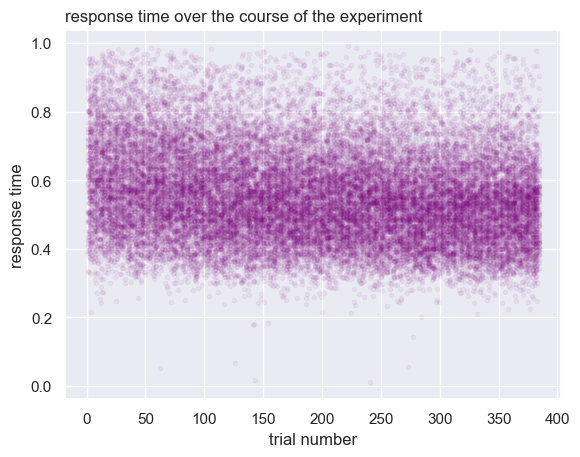

In [222]:
# how does reaction time develope over time? learning effects? do get people faster? 
# https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/ 

# Plot with transparency
plt.plot( data["trial_index_within_participant"], data["owner_confirm_rt"], data=data, linestyle='', marker='o', markersize=3, alpha=0.05, color="purple")
 
# Titles
plt.xlabel('trial number')
plt.ylabel('response time')
plt.title('response time over the course of the experiment', loc='left')
plt.show()

### Analysis related to handedness

Is there any relation between the handedness of participants and their choices of colors or response times?

In [223]:
# Do people prefer one choice when deciding for color? E.g., do right handed people rather choose with 'k' than 'g' when selecting one color
# TODO: we sort out trials with errors, correct total trial number because this is for complete set of trials?
total_trials = 192 # only the ones where you choose

choice_loaction_by_handedness = data[data['chooser'] == 'you']
choice_loaction_by_handedness = choice_loaction_by_handedness.groupby(['participant', 'choice_location']).agg(
    choice_location_count=('choice_location', 'count')).reset_index()

# Merge handedenss of participants
choice_loaction_by_handedness = choice_loaction_by_handedness.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

# Create ration column
choice_loaction_by_handedness['ratio'] = choice_loaction_by_handedness['choice_location_count'] / total_trials

choice_loaction_by_handedness.groupby(['handedness', 'choice_location']).agg(avg_ratio=('ratio', 'mean'),participant_count =('participant','count')).reset_index()


,handedness,choice_location,avg_ratio,participant_count
0,left,left,0.434375,5
1,left,right,0.478125,5
2,other,left,0.052083,1
3,other,right,0.916667,1
4,right,left,0.449287,76
5,right,right,0.460458,76


In [224]:
# Is the reaction time of outcome attribution related to handedness and answer key? E.g., are right handed people faster responding to 'keep' than 'give'
rt_by_confirm_keys = data.groupby(['participant', 'owner_confirm_keys']).agg(
    average_response_time=('owner_confirm_rt', 'mean'),
    median_response_time=('owner_confirm_rt', 'median')).reset_index()

# Merge handedenss of participants
rt_by_confirm_keys = rt_by_confirm_keys.merge(survey_data[['participant', 'handedness']], on='participant', how='left')

rt_by_confirm_keys.groupby(['handedness','owner_confirm_keys']).agg(average_response_time=('average_response_time', 'mean')).reset_index()

,handedness,owner_confirm_keys,average_response_time
0,left,g,0.588106
1,left,k,0.549935
2,other,g,0.460075
3,other,k,0.458896
4,right,g,0.574658
5,right,k,0.541669


### Extra

#### Repition driven response time

Are particpant faster when two times using the same key? e.g. first choose right square or confirm right square and proceed with keep (which is again the right key)?

In [225]:
# Select subset from data with only relevant columns
subset = data.loc[:, ['participant', 'trial_index_within_participant', 'choice_location', 'owner_confirm_keys', 'owner_confirm_rt']].copy()

# Create identifier column: location_decision_owner_same = True / False
subset.loc[:, 'location_decision_owner_same'] = (
    ((subset['choice_location'] == 'left') & (subset['owner_confirm_keys'] == 'g')) |
    ((subset['choice_location'] == 'right') & (subset['owner_confirm_keys'] == 'k'))
)

subset = subset.groupby(['participant','location_decision_owner_same']).agg(average_response_time=('owner_confirm_rt', 'mean'))

# Aggregate owner_confirm_rt
subset.groupby(['location_decision_owner_same']).agg(average_response_time=('average_response_time', 'mean'))

,average_response_time
location_decision_owner_same,
False,0.557131
True,0.557785


#### Balance dependent response time

Is it easier to give when cozmo anyways has a lower balance than have?

In [226]:
#Als variable anschauen wie viel gewinn oder Verlust Cozmo schon hatte.

#### "Win-stay lose-shift"-Verhalten

Normalerweise geht man davon aus, dass Leute nach einem Win mit höherer Wahrscheinlichkeit das gleiche Item nochmal wählen (bzw. das andere nach einem Loss). Hier wäre es interessant, ob Leute stärkeres "win-stay lose-shift" Verhalten zeigen, wen die Wahl im letzten Trial von ihnen selbst getroffen wurden, anstatt von dem Roboter (d.h. ob sie die Outcomes ihrer eigenen Entscheidungen eher informativ finden)

--> wir haben gar nicht unbedingt immer trials mit dem gleichen chooser in folge; ist nicht unbedingt relevant kann auch sein dass cozmo als chooser informativ ist
--> aber nur trials in denen das following trial von einem selbst gewählt wurde!!

In [291]:
# Analysis idea Jakob had and was mentioning in his e-mail
win_stay_subset = data.loc[:, ['participant','block','trial_index_within_block','chooser','right_color','left_color','choice_location','value']].copy()

# Store color of decision in new column
win_stay_subset['choice_color'] = np.where(win_stay_subset['choice_location'] == 'left', win_stay_subset['left_color'], win_stay_subset['right_color'])

# Create a second subset which will be merged to first one as 'second choice trial'
win_stay_subset_second_trial = win_stay_subset
win_stay_subset_second_trial = win_stay_subset_second_trial.loc[win_stay_subset_second_trial['chooser'] == 'you', :]
win_stay_subset_second_trial.loc[:, 'merge_index'] = win_stay_subset_second_trial['trial_index_within_block'] - 1 # correct index to add following trial to first
win_stay_subset_second_trial['following_trial_choice_color'] = win_stay_subset_second_trial['choice_color'] # new column for second choice color
win_stay_subset_second_trial = win_stay_subset_second_trial.loc[:, ['participant','block','trial_index_within_block','merge_index','following_trial_choice_color']].copy() # select relevant columns

# Filter first subset again
win_stay_subset = win_stay_subset.loc[:, ['participant','block','trial_index_within_block','chooser','value','choice_color']].copy()

# Create merge index, to have same name for merge
win_stay_subset['merge_index'] = win_stay_subset['trial_index_within_block']

# Merge to datasets
win_stay_subset = win_stay_subset.merge(win_stay_subset_second_trial, on = ['participant','block','merge_index'], how = 'inner')

# Check if color of decision in two trials in a row was same: if choice_color and following is same than true
win_stay_subset['same_choice'] = win_stay_subset['choice_color'] == win_stay_subset['following_trial_choice_color']

# Change index into string for concat
win_stay_subset['trial_index_within_block_x'] = win_stay_subset['trial_index_within_block_x'].astype(int).astype('string')
win_stay_subset['trial_index_within_block_y'] = win_stay_subset['trial_index_within_block_y'].astype(int).astype('string')
win_stay_subset['trial_combo'] = win_stay_subset['trial_index_within_block_x'] + '_' + win_stay_subset['trial_index_within_block_y']

# Filter first subset again
win_stay_subset = win_stay_subset.loc[:, ['participant','block','trial_combo','chooser','value','same_choice']].copy()

# Group by participant, chooser, value, same color
win_stay_subset = win_stay_subset.groupby([ 'participant','chooser','value','same_choice']).agg(count=('same_choice', 'count')).reset_index()

# Add base for ratio (number of trials per participant)
denominator = win_stay_subset.groupby([ 'participant']).agg(total_trials=('count', 'sum'))

# Merge denominator
win_stay_subset = win_stay_subset.merge(denominator, on = 'participant', how = 'left')

# calculate ratio
win_stay_subset['ratio'] = round((win_stay_subset['count'] / win_stay_subset['total_trials']),2)

# aggregate ratio over all participants
win_stay_subset = win_stay_subset.groupby(['chooser','value','same_choice']).agg(avg_ratio=('ratio', 'mean')).reset_index()

# Round ratio
win_stay_subset['avg_ratio'] = round(win_stay_subset['avg_ratio'],2)

# Print
print(win_stay_subset)

  chooser value  same_choice  avg_ratio
0   cozmo  lose        False       0.13
1   cozmo  lose         True       0.13
2   cozmo   win        False       0.12
3   cozmo   win         True       0.14
4     you  lose        False       0.12
5     you  lose         True       0.13
6     you   win        False       0.10
7     you   win         True       0.14


/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_89582/1442061293.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_stay_subset_second_trial.loc[:, 'merge_index'] = win_stay_subset_second_trial['trial_index_within_block'] - 1 # correct index to add following trial to first
/var/folders/94/kbz524cd32j80_2tm_hwnr780000gn/T/ipykernel_89582/1442061293.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  win_stay_subset_second_trial['following_trial_choice_color'] = win_stay_subset_second_trial[